<a href="https://colab.research.google.com/github/danielsoy/ALOCC-CVPR2018/blob/master/unsupervised_anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised anomaly detection using Anomalib library

_________________________
Author: Dennis Hernando NÚÑEZ FERNÁNDEZ    
Personal website: [https://dennishnf.com](https://dennishnf.com)    
_________________________    

## Pre-installation settings

All the experiments were runned on a machine with Ubuntu 20.04 LTS and NVIDIA GeForce GTX 1050 Ti with 4GB.    
In addition, this notebook was locally implemented using Conda and in a virtual environment.     
Therefore, to create a virtual enviroment in Conda, the following commands were introduced in the terminal:    

```
$ yes | conda create -n anomalib_env python=3.8
$ conda activate anomalib_env
```

## Installing AnomaLib

In [ ]:
PROJECT_PATH = '/home/dennishnf/Desktop/unsupervised-anomaly-detection'

In [ ]:
%cd {PROJECT_PATH}

/home/dennishnf/Desktop/unsupervised-anomaly-detection


In [ ]:
!ls

dataset    unsupervised-anomaly-detection.html
README.md  unsupervised-anomaly-detection.ipynb


In [ ]:
!git clone https://github.com/openvinotoolkit/anomalib.git

Cloning into 'anomalib'...
remote: Enumerating objects: 21905, done.
remote: Counting objects: 100% (3444/3444), done.
remote: Compressing objects: 100% (1201/1201), done.
remote: Total 21905 (delta 1974), reused 3122 (delta 1748), pack-reused 18461
Receiving objects: 100% (21905/21905), 49.53 MiB | 4.14 MiB/s, done.
Resolving deltas: 100% (12846/12846), done.


In [ ]:
%cd anomalib

/home/dennishnf/Desktop/unsupervised-anomaly-detection/anomalib


In [ ]:
!ls

anomalib	    CONTRIBUTING.md  markdownlint.rb  setup.py
CHANGELOG.md	    Dockerfile	     notebooks	      tests
CITATION.cff	    docs	     pyproject.toml   third-party-programs.txt
CODE_OF_CONDUCT.md  LICENSE	     README.md	      tools
configs		    MANIFEST.in      requirements     tox.ini


In [ ]:
!pip install -e . -q

In [ ]:
import anomalib
anomalib.__version__

'0.3.6'

## Importing libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os, pprint, yaml, warnings, math, glob, cv2, random, logging
from IPython.display import Image

In [ ]:
def warn(*args, **kwargs):
    pass
warnings.warn = warn
warnings.filterwarnings('ignore')
logger = logging.getLogger("anomalib")

In [ ]:
import anomalib
from pytorch_lightning import Trainer, seed_everything
from anomalib.config import get_configurable_parameters
from anomalib.data import get_datamodule
from anomalib.models import get_model
from anomalib.utils.callbacks import LoadModelCallback, get_callbacks
from anomalib.utils.loggers import configure_logger, get_experiment_logger

In [ ]:
import torch
print("Torch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("GPU availability:", torch.cuda.is_available())
print("Number of GPU devices:", torch.cuda.device_count())      
print("Name of current GPU:", torch.cuda.get_device_name(0))  

Torch version: 1.11.0+cu102
CUDA version: 10.2
GPU availability: True
Number of GPU devices: 1
Name of current GPU: NVIDIA GeForce GTX 1050 Ti


## Checking the dataset

In [ ]:
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)

In [ ]:
%cd {PROJECT_PATH}/dataset/MVTec/

/home/dennishnf/Desktop/unsupervised-anomaly-detection/dataset/MVTec


In [ ]:
!ls

metal_nut


In [ ]:
list_files(PROJECT_PATH+"/dataset/MVTec/")

/
metal_nut/
    ground_truth/
        color/
        bent/
        flip/
        scratch/
    test/
        color/
        bent/
        flip/
        good/
        scratch/
    train/
        good/


## Models

### PaDiM: A Patch Distribution Modeling Framework for Anomaly Detection and Localization

Paper: [PaDiM](https://arxiv.org/pdf/2011.08785.pdf)

PaDiM is a patch based algorithm. It relies on a pre-trained CNN feature extractor. The image is broken into patches and embeddings are extracted from each patch using different layers of the feature extractors. The activation vectors from different layers are concatenated to get embedding vectors carrying information from different semantic levels and resolutions. This helps encode fine grained and global contexts. However, since the generated embedding vectors may carry redundant information, dimensions are reduced using random selection. A multivariate gaussian distribution is generated for each patch embedding across the entire training batch. Thus, for each patch of the set of training images, we have a different multivariate gaussian distribution. These gaussian distributions are represented as a matrix of gaussian parameters.

During inference, Mahalanobis distance is used to score each patch position of the test image. It uses the inverse of the covariance matrix calculated for the patch during training. The matrix of Mahalanobis distances forms the anomaly map with higher scores indicating anomalous regions.

![PaDiM Architecture](https://raw.githubusercontent.com/openvinotoolkit/anomalib/development/docs/source/images/padim/architecture.jpg "PaDiM Architecture")

### PatchCore

Paper: [PatchCore](https://arxiv.org/pdf/2106.08265.pdf)

The PatchCore algorithm is based on the idea that an image can be classified as anomalous as soon as a single patch is anomalous. The input image is tiled. These tiles act as patches which are fed into the neural network. It consists of a single pre-trained network which is used to extract "mid" level features patches. The "mid" level here refers to the feature extraction layer of the neural network model. Lower level features are generally too broad and higher level features are specific to the dataset the model is trained on. The features extracted during training phase are stored in a memory bank of neighbourhood aware patch level features.

During inference this memory bank is coreset subsampled. Coreset subsampling generates a subset which best approximates the structure of the available set and allows for approximate solution finding. This subset helps reduce the search cost associated with nearest neighbour search. The anomaly score is taken as the maximum distance between the test patch in the test patch collection to each respective nearest neighbour.

![PatchCore Architecture](https://raw.githubusercontent.com/openvinotoolkit/anomalib/development/docs/source/images/patchcore/architecture.jpg "PatchCore Architecture")

### Student-Teacher Feature Pyramid Matching for Unsupervised Anomaly Detection

Paper: [STFPM](https://arxiv.org/pdf/2103.04257.pdf)

STFPM algorithm consists of a pre-trained teacher network and a student network with identical architecture. The student network learns the distribution of anomaly-free images by matching the features with the counterpart features in the teacher network. Multi-scale feature matching is used to enhance robustness. This hierarchical feature matching enables the student network to receive a mixture of multi-level knowledge from the feature pyramid thus allowing for anomaly detection of various sizes.

During inference, the feature pyramids of teacher and student networks are compared. Larger difference indicates a higher probability of anomaly occurrence.

![STFPM Architecture](https://raw.githubusercontent.com/openvinotoolkit/anomalib/development/docs/source/images/stfpm/architecture.jpg "STFPM Architecture")

### FastFlow: Unsupervised Anomaly Detection and Localization via 2D Normalizing Flows

Paper: [FastFlow](https://arxiv.org/abs/2111.07677)

FastFlow is a two-dimensional normalizing flow-based probability distribution estimator. It can be used as a plug-in module with any deep feature extractor, such as ResNet and vision transformer, for unsupervised anomaly detection and localisation. In the training phase, FastFlow learns to transform the input visual feature into a tractable distribution, and in the inference phase, it assesses the likelihood of identifying anomalies.

![FastFlow Architecture](https://raw.githubusercontent.com/openvinotoolkit/anomalib/development/docs/source/images/fastflow/architecture.jpg "FastFlow Architecture")

### Anomaly Detection via Reverse Distillation from One-Class Embedding

Paper: [Reverse Distillation](https://arxiv.org/pdf/2201.10703v2.pdf)

Reverse Distillation model consists of three networks. The first is a pre-trained feature extractor (E). The next two are the one-class bottleneck embedding (OCBE) and the student decoder network (D). The backbone E is a ResNet model pre-trained on ImageNet dataset. During the forward pass, features from three ResNet block are extracted. These features are encoded by concatenating the three feature maps using the multi-scale feature fusion block of OCBE and passed to the decoder D. The decoder network is symmetrical to the feature extractor but reversed. During training, outputs from these symmetrical blocks are forced to be similar to the corresponding feature extractor layers by using cosine distance as the loss metric.

During testing, a similar step is followed but this time the cosine distance between the feature maps is used to indicate the presence of anomalies. The distance maps from all the three layers are up-sampled to the image size and added (or multiplied) to produce the final feature map. Gaussian blur is applied to the output map to make it smoother. Finally, the anomaly map is generated by applying min-max normalization on the output map.

![Anomaly Detection via Reverse Distillation from One-Class Embedding Architecture](https://raw.githubusercontent.com/openvinotoolkit/anomalib/development/docs/source/images/reverse_distillation/architecture.png "Reverse Distillation Architecture")


## Setting config files

In [ ]:
%cd {PROJECT_PATH}

/home/dennishnf/Desktop/unsupervised-anomaly-detection


In [ ]:
!ls

anomalib   unsupervised-anomaly-detection.html
dataset    unsupervised-anomaly-detection.ipynb
README.md


In [ ]:
CONFIG_PATHS = PROJECT_PATH + '/anomalib/anomalib/models'
MODEL_CONFIG_PAIRS = {
    'patchcore': f'{CONFIG_PATHS}/patchcore/config.yaml',
    'padim':     f'{CONFIG_PATHS}/padim/config.yaml',
    'cflow':     f'{CONFIG_PATHS}/cflow/config.yaml',
    'dfkde':     f'{CONFIG_PATHS}/dfkde/config.yaml',
    'dfm':       f'{CONFIG_PATHS}/dfm/config.yaml',
    'ganomaly':  f'{CONFIG_PATHS}/ganomaly/config.yaml',
    'stfpm':     f'{CONFIG_PATHS}/stfpm/config.yaml',
    'fastflow':  f'{CONFIG_PATHS}/fastflow/config.yaml',
    'draem':     f'{CONFIG_PATHS}/draem/config.yaml',
    'reverse_distillation': f'{CONFIG_PATHS}/reverse_distillation/config.yaml',
}

In [ ]:
MODEL = 'reverse_distillation'
print(open(os.path.join(MODEL_CONFIG_PAIRS[MODEL]), 'r').read())

dataset:
  name: mvtec #options: [mvtec, btech, folder]
  format: mvtec
  path: ./datasets/MVTec
  category: bottle
  task: segmentation
  image_size: 256
  train_batch_size: 32
  test_batch_size: 32
  inference_batch_size: 32
  num_workers: 8
  transform_config:
    train: null
    val: null
  create_validation_set: false
  tiling:
    apply: false
    tile_size: 64
    stride: null
    remove_border_count: 0
    use_random_tiling: False
    random_tile_count: 16

model:
  name: reverse_distillation
  lr: 0.005
  backbone: wide_resnet50_2
  pre_trained: true
  layers:
    - layer1
    - layer2
    - layer3
  early_stopping:
    patience: 3
    metric: pixel_AUROC
    mode: max
  beta1: 0.5
  beta2: 0.99
  normalization_method: min_max # options: [null, min_max, cdf]
  anomaly_map_mode: multiply

metrics:
  image:
    - F1Score
    - AUROC
  pixel:
    - F1Score
    - AUROC
  threshold:
    image_default: 0
    pixel_default: 0
    adaptive: true

visualization:
  show_images: False # 

In [ ]:
new_update = {
    "path": PROJECT_PATH + '/dataset/MVTec',
    'task': 'segmentation',
    'category': 'metal_nut', 
    'image_size': 256,
    'train_batch_size': 4,
    'test_batch_size': 4,
    'max_epochs': 4,
    'seed': 101
}

In [ ]:
# update yaml key's value
def update_yaml(old_yaml, new_yaml, new_update):
    # load yaml
    with open(old_yaml) as f:
        old = yaml.safe_load(f)
                  
    temp = []
    def set_state(old, key, value):
        if isinstance(old, dict):
            for k, v in old.items():
                if k == 'project':
                    temp.append(k)
                if k == key:
                    if temp and k == 'path':
                        # right now, we don't wanna change `project.path`
                        continue
                    old[k] = value
                elif isinstance(v, dict):
                    set_state(v, key, value)
    
    # iterate over the new update key-value pari
    for key, value in new_update.items():
        set_state(old, key, value)
    
    # save the updated / modified yaml file
    with open(new_yaml, 'w') as f:
        yaml.safe_dump(old, f, default_flow_style=False)

In [ ]:
# let's set a new path location of new config file 
new_yaml_path = CONFIG_PATHS + '/' + MODEL + '_new.yaml'

In [ ]:
new_yaml_path

'/home/dennishnf/Desktop/unsupervised-anomaly-detection/anomalib/anomalib/models/reverse_distillation_new.yaml'

In [ ]:
# run the update yaml method to update desired key's values
update_yaml(MODEL_CONFIG_PAIRS[MODEL], new_yaml_path, new_update)        

In [ ]:
with open(new_yaml_path) as f:
    updated_config = yaml.safe_load(f)
pprint.pprint(updated_config) # check if it's updated

{'dataset': {'category': 'metal_nut',
             'create_validation_set': False,
             'format': 'mvtec',
             'image_size': 256,
             'inference_batch_size': 32,
             'name': 'mvtec',
             'num_workers': 8,
             'path': '/home/dennishnf/Desktop/unsupervised-anomaly-detection/dataset/MVTec',
             'task': 'segmentation',
             'test_batch_size': 4,
             'tiling': {'apply': False,
                        'random_tile_count': 16,
                        'remove_border_count': 0,
                        'stride': None,
                        'tile_size': 64,
                        'use_random_tiling': False},
             'train_batch_size': 4,
             'transform_config': {'train': None, 'val': None}},
 'logging': {'log_graph': False, 'logger': []},
 'metrics': {'image': ['F1Score', 'AUROC'],
             'pixel': ['F1Score', 'AUROC'],
             'threshold': {'adaptive': True,
                           'imag

##  Training

In [ ]:
if updated_config['project']['seed'] != 0:
    print(updated_config['project']['seed'])
    seed_everything(updated_config['project']['seed'])

Global seed set to 101


101


In [ ]:
# It will return the configurable parameters in DictConfig object.
config = get_configurable_parameters(
    model_name=updated_config['model']['name'],
    config_path=new_yaml_path
)

In [ ]:
# pass the config file to model, logger, callbacks and datamodule
model      = get_model(config)
experiment_logger = get_experiment_logger(config)
callbacks  = get_callbacks(config)
datamodule = get_datamodule(config)

Transform configs has not been provided. Images will be normalized using ImageNet statistics.
Transform configs has not been provided. Images will be normalized using ImageNet statistics.


In [ ]:
# start training
trainer = Trainer(**config.trainer, logger=experiment_logger, callbacks=callbacks)
trainer.fit(model=model, datamodule=datamodule)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type                     | Params
-------------------------------------------------------------------
0 | image_threshold       | AdaptiveThreshold        | 0     
1 | pixel_threshold       | AdaptiveThreshold        | 0     
2 | model                 | ReverseDistillationModel | 80.6 M
3 | image_metrics         | 

Epoch 1:  65%|██████████████▍       | 55/84 [00:30<00:16,  1.79it/s, loss=0.327]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 29/29 [00:05<00:00,  6.10it/s]
Epoch 1: 100%|█| 84/84 [00:41<00:00,  2.05it/s, loss=0.327, pixel_F1Score=0.770,
Epoch 3:  65%|▋| 55/84 [00:38<00:20,  1.42it/s, loss=0.246, pixel_F1Score=0.770,
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   3%|▋                  | 1/29 [00:00<00:14,  1.91it/s]
Epoch 3:  67%|▋| 56/84 [00:44<00:22,  1.26it/s, loss=0.246, pixel_F1Score=0.770,
Validation DataLoader 0:   7%|█▎                 | 2/29 [00:00<00:10,  2.50it/s]
Epoch 3:  68%|▋| 57/84 [00:44<00:21,  1.27it/s, loss=0.246, pixel_F1Score=0.770,
Validation DataLoader 0:  10%|█▉                 | 3/29 [00:01<00:08,  2.98it/s]
Epoch 3:  69%|▋| 58/84 [00:45<00:20,  1.29it/s, loss=0.246, pixel_F1Score=0.770,
Validation DataLoader 0:  14%|██▌                | 4/29 [00:01<00:07,  3.45it/s]
Epoch 3:  70%|▋| 59/84 [00:45<00:19,  1.30it/s,

Validation DataLoader 0:  59%|██████████▌       | 17/29 [00:03<00:02,  5.25it/s]
Epoch 3:  86%|▊| 72/84 [00:47<00:07,  1.50it/s, loss=0.246, pixel_F1Score=0.770,
Validation DataLoader 0:  62%|███████████▏      | 18/29 [00:04<00:02,  5.26it/s]
Epoch 3:  87%|▊| 73/84 [00:48<00:07,  1.52it/s, loss=0.246, pixel_F1Score=0.770,
Validation DataLoader 0:  66%|███████████▊      | 19/29 [00:04<00:01,  5.44it/s]
Epoch 3:  88%|▉| 74/84 [00:48<00:06,  1.53it/s, loss=0.246, pixel_F1Score=0.770,
Validation DataLoader 0:  69%|████████████▍     | 20/29 [00:04<00:01,  5.48it/s]
Epoch 3:  89%|▉| 75/84 [00:48<00:05,  1.55it/s, loss=0.246, pixel_F1Score=0.770,
Validation DataLoader 0:  72%|█████████████     | 21/29 [00:04<00:01,  5.60it/s]
Epoch 3:  90%|▉| 76/84 [00:48<00:05,  1.56it/s, loss=0.246, pixel_F1Score=0.770,
Validation DataLoader 0:  76%|█████████████▋    | 22/29 [00:04<00:01,  5.65it/s]
Epoch 3:  92%|▉| 77/84 [00:48<00:04,  1.58it/s, loss=0.246, pixel_F1Score=0.770,
Validation DataLoader 0:  79

## Evaluation

In [ ]:
# load best model from checkpoint before evaluating
load_model_callback = LoadModelCallback(
    weights_path=trainer.checkpoint_callback.best_model_path
)
trainer.callbacks.insert(0, load_model_callback)
trainer.test(model=model, datamodule=datamodule)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|█████████████████████| 29/29 [00:32<00:00,  1.12s/it]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       image_AUROC          0.5830889344215393
      image_F1Score         0.8942307829856873
       pixel_AUROC          0.9722244739532471
      pixel_F1Score         0.8017732501029968
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'pixel_F1Score': 0.8017732501029968,
  'pixel_AUROC': 0.9722244739532471,
  'image_F1Score': 0.8942307829856873,
  'image_AUROC': 0.5830889344215393}]

## Visualization of the prediction on the test dataset

In [ ]:
RESULT_PATH = os.path.join(
    updated_config['project']['path'],
    updated_config['model']['name'],
    updated_config['dataset']['format'], 
    updated_config['dataset']['category']
)
RESULT_PATH

'./results/reverse_distillation/mvtec/metal_nut'

In [ ]:
# a simple function to visualize the model's prediction (anomaly heatmap)
def visualiz(paths, n_images, is_random=True, figsize=(16, 16)):
    for i in range(n_images):
        image_name = paths[i]
        if is_random: image_name = random.choice(paths)
        img = cv2.imread(image_name)[:,:,::-1]
        
        category_type = image_name.split('/')[-4:-3:][0]
        defected_type = image_name.split('/')[-2:-1:][0]
        
        plt.figure(figsize=figsize)
        plt.imshow(img)
        plt.title(
            f"Category : {category_type} and Defected Type : {defected_type} \n {image_name}", 
            fontdict={'fontsize': 20, 'fontweight': 'medium'}
        )
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
    plt.show()

In [ ]:
for content in os.listdir(RESULT_PATH):
    if content == 'images':
        full_path = glob.glob(os.path.join(RESULT_PATH, content, '**',  '*.png'), recursive=True)
        print('Total Image ', len(full_path))
        print(full_path[0].split('/'))
        print(full_path[0].split('/')[-2:-1:])
        print(full_path[0].split('/')[-4:-3:])

Total Image  117
['.', 'results', 'reverse_distillation', 'mvtec', 'metal_nut', 'images', 'image_ROC.png']
['images']
['mvtec']


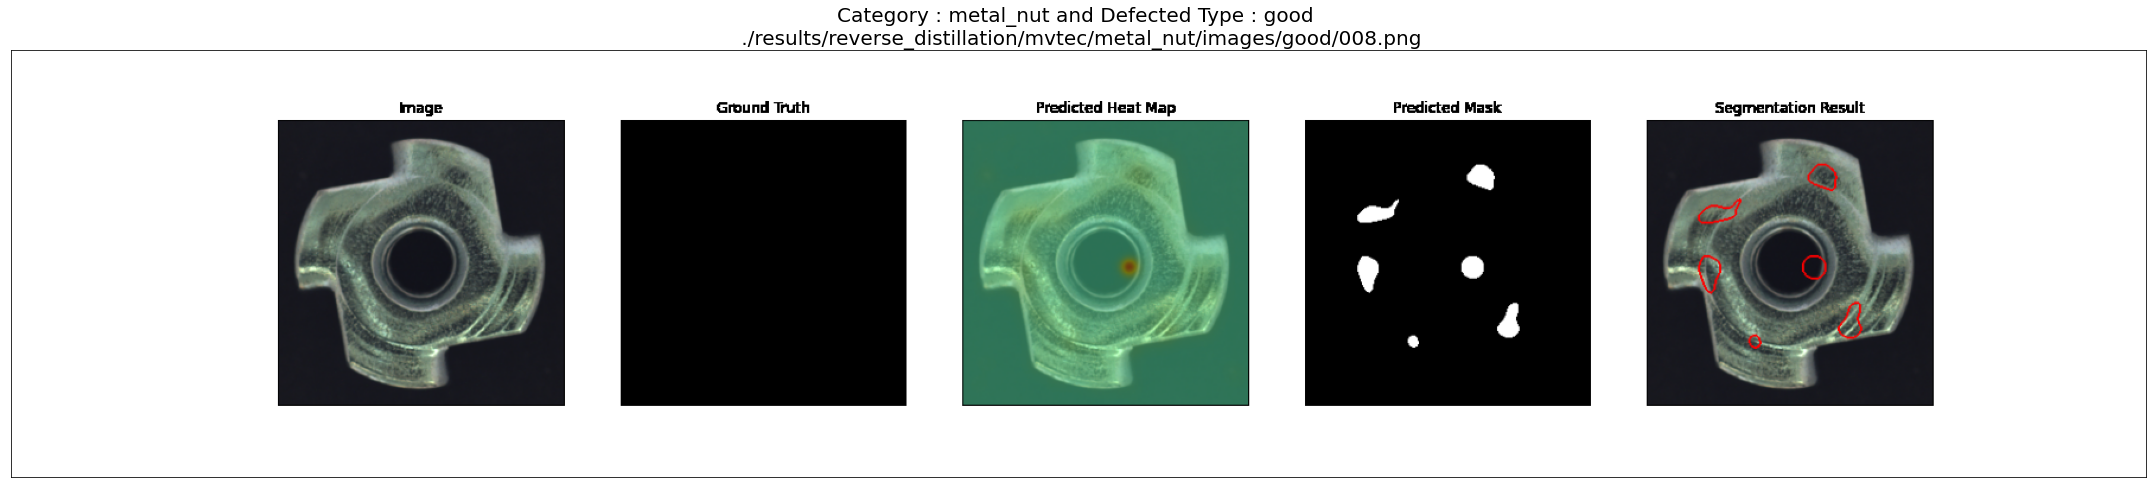

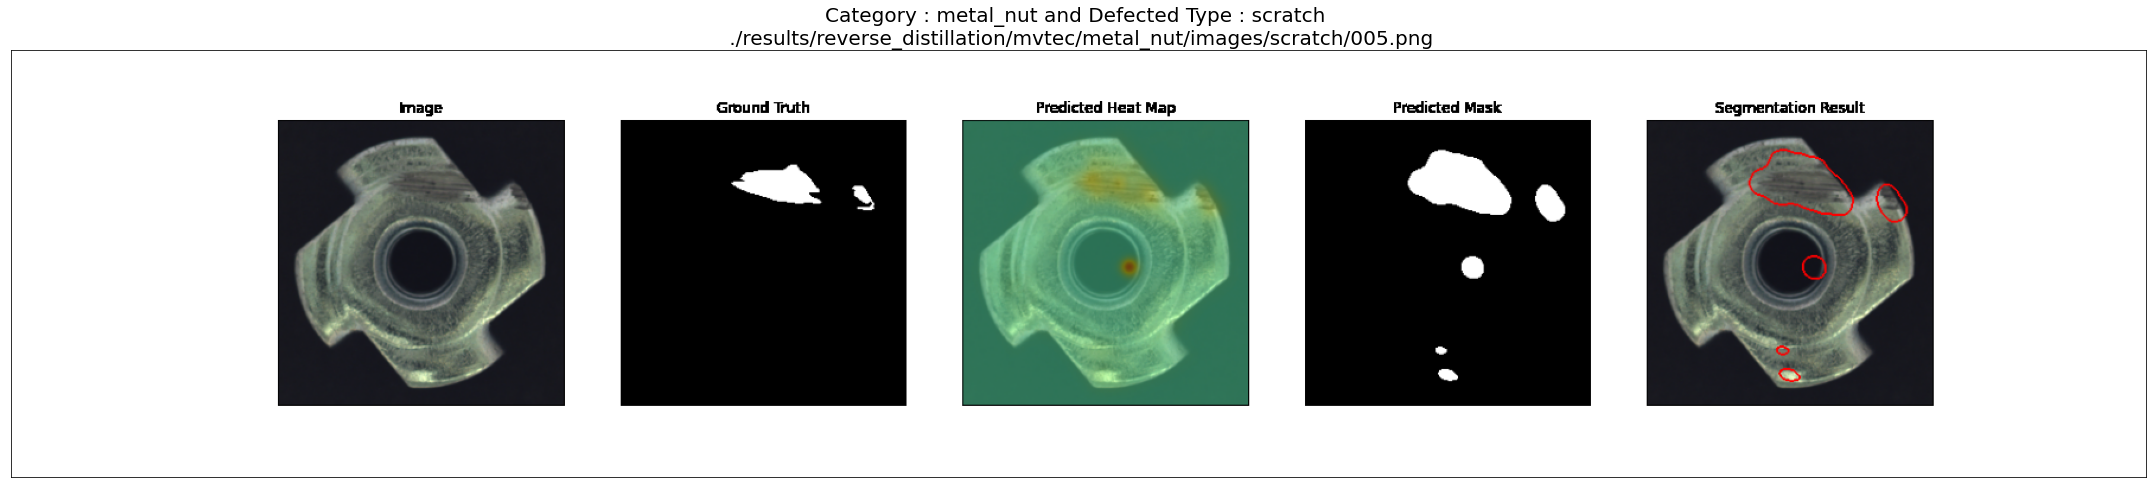

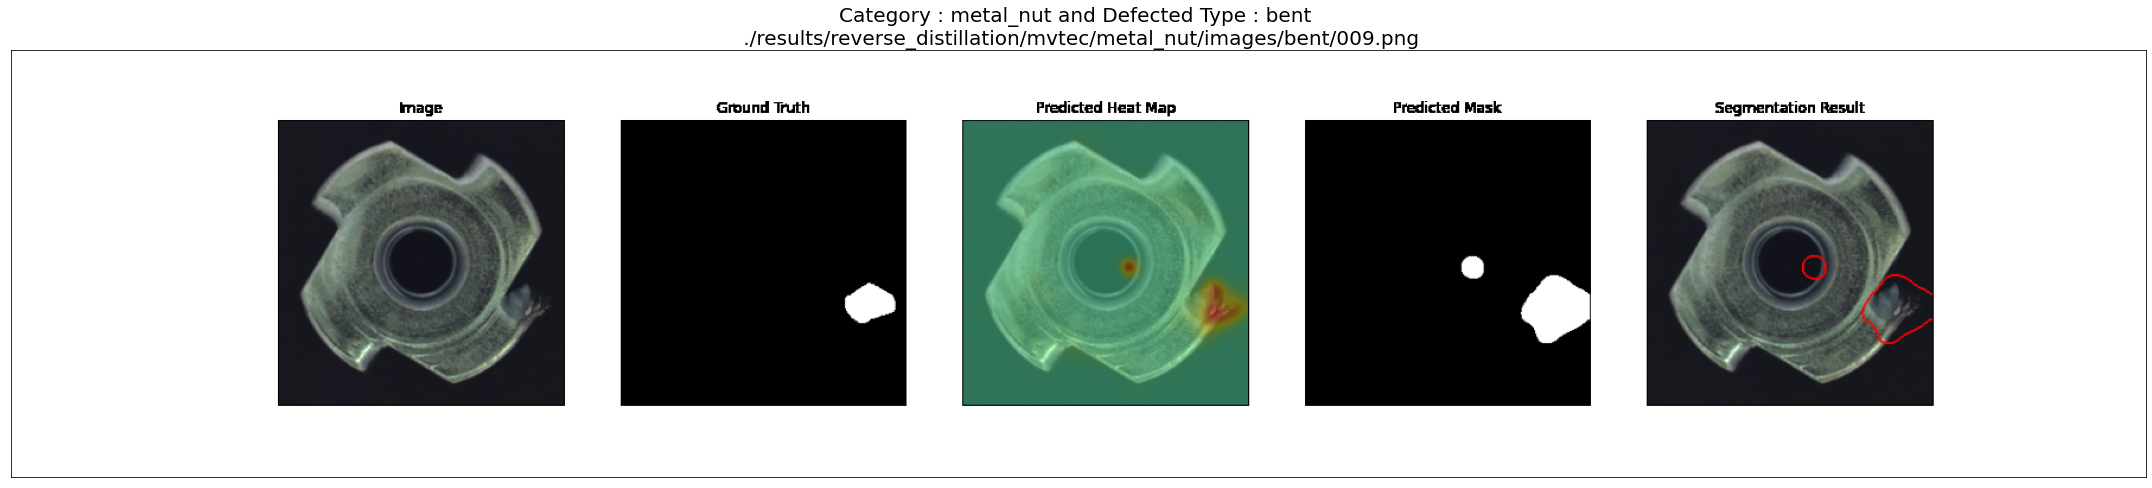

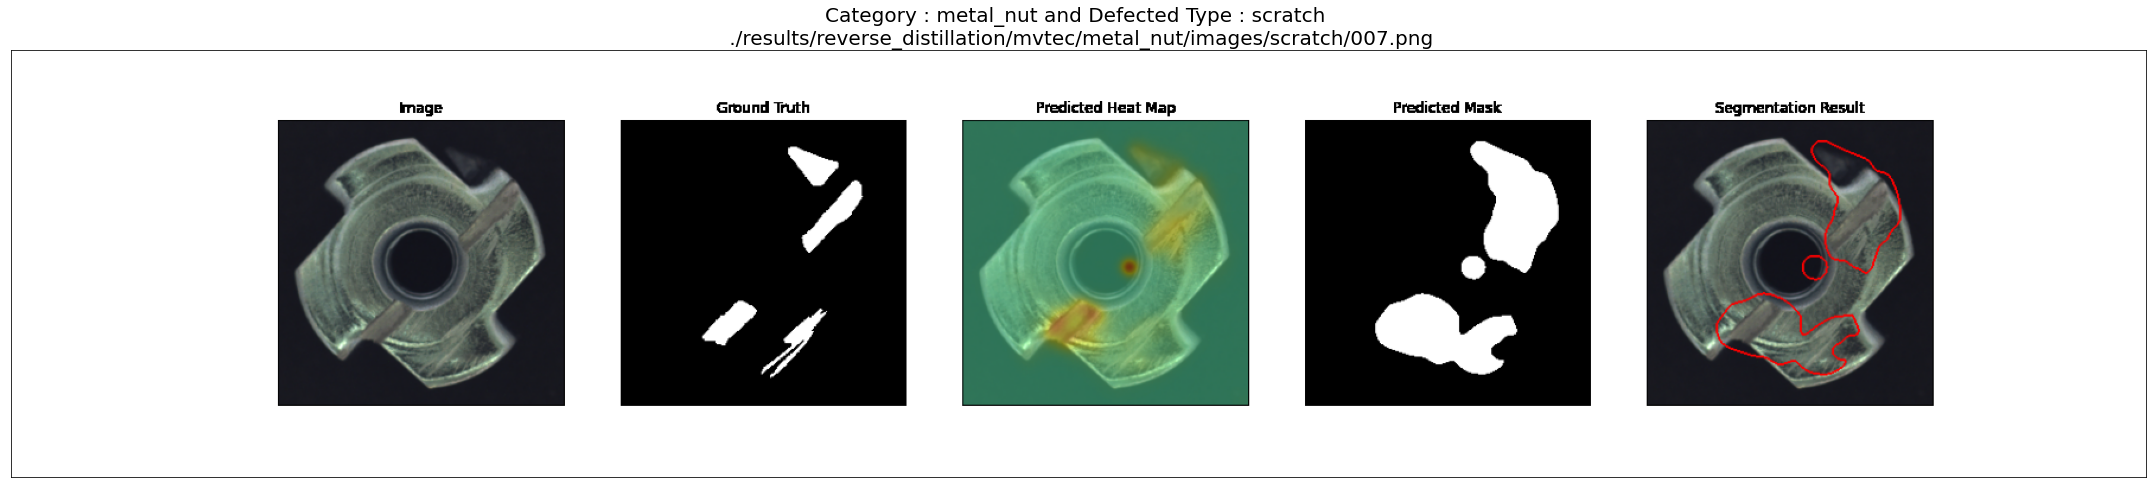

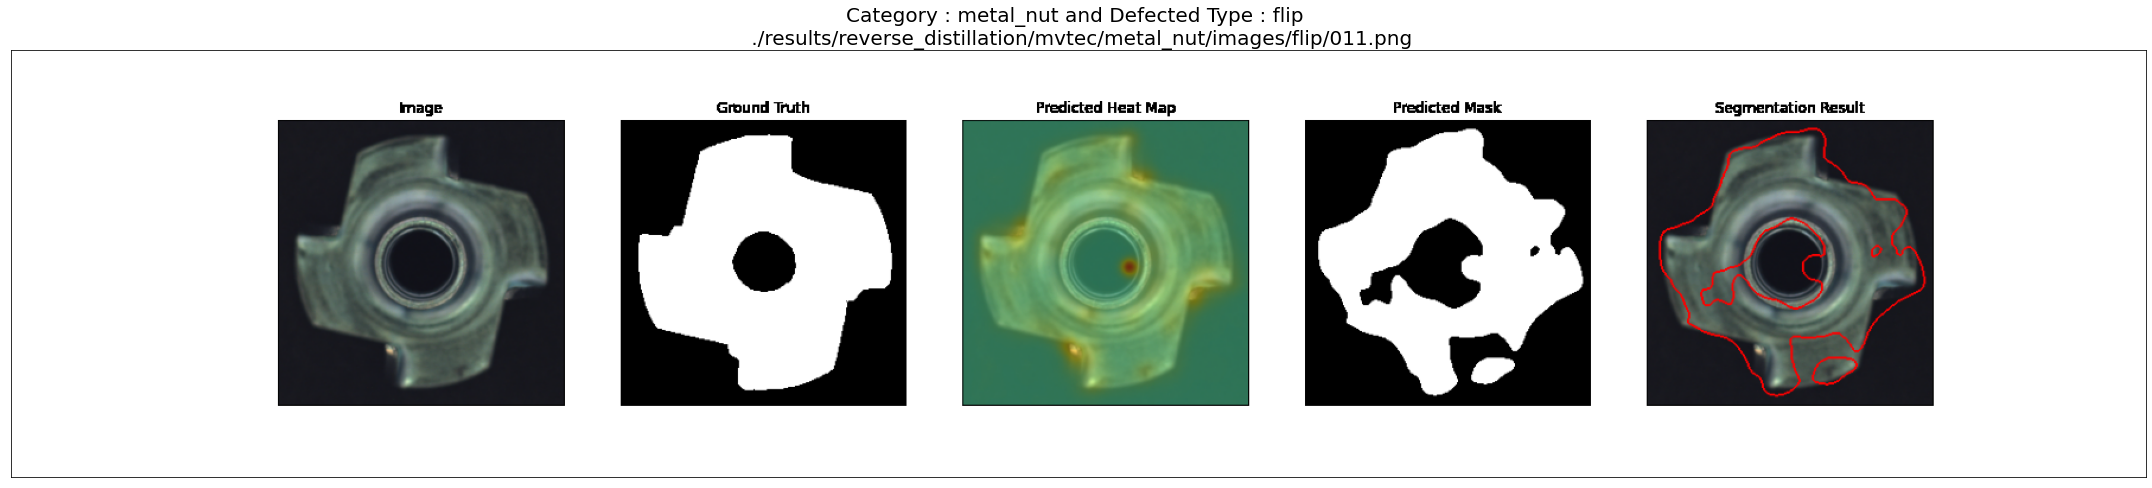

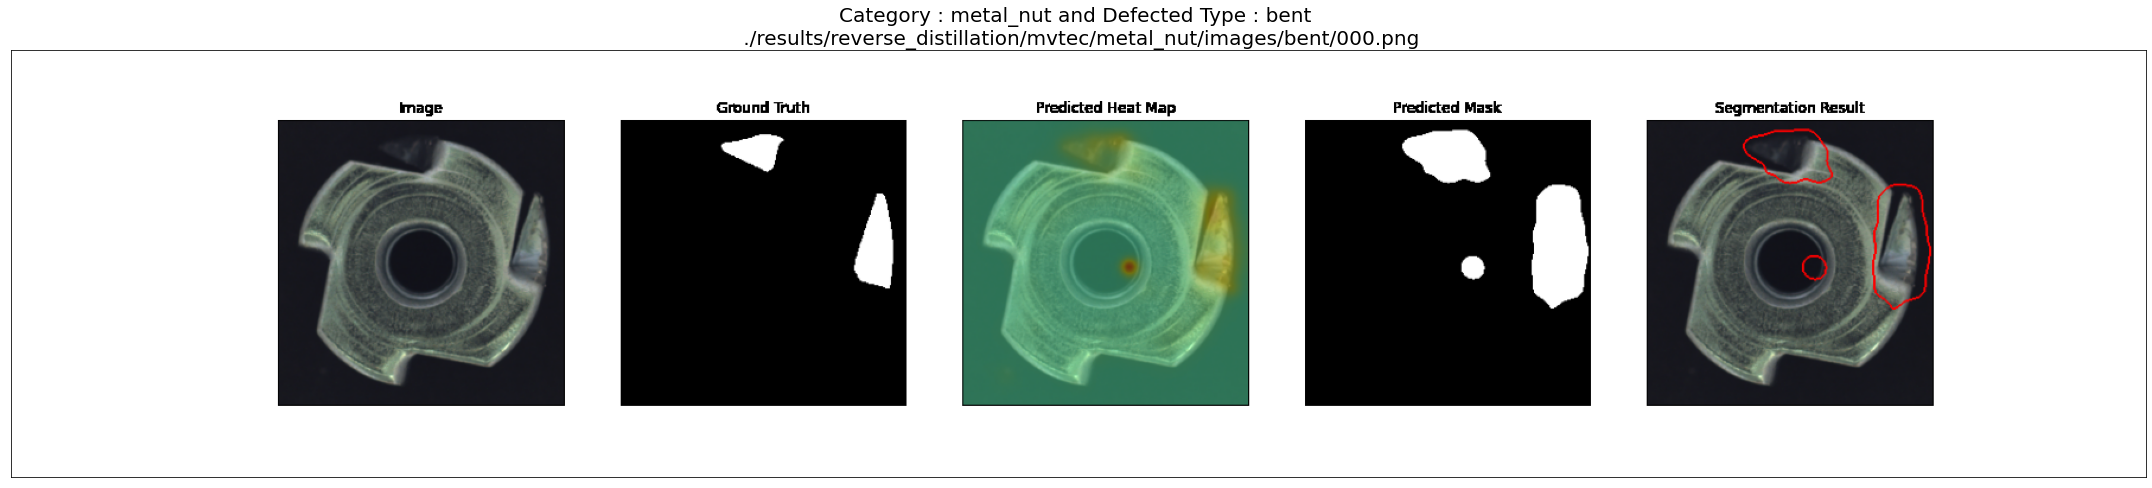

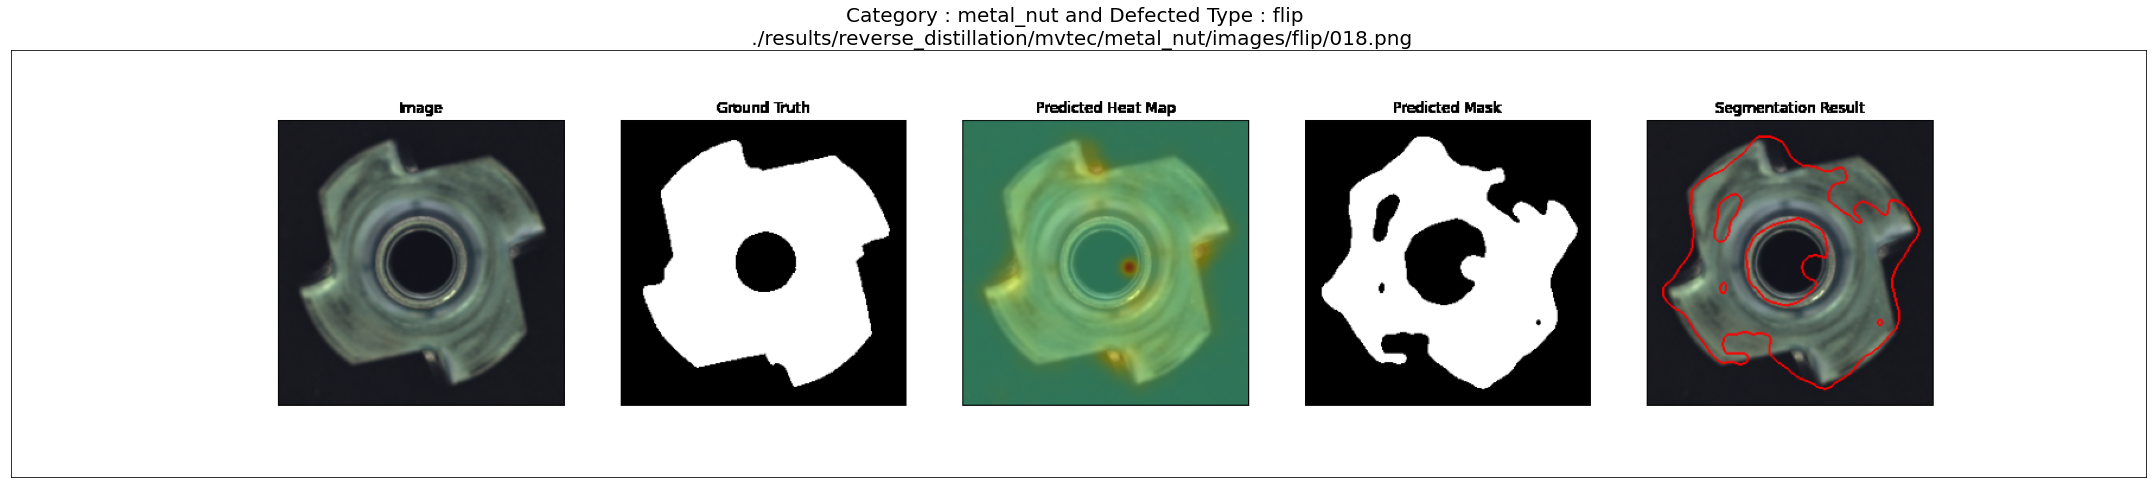

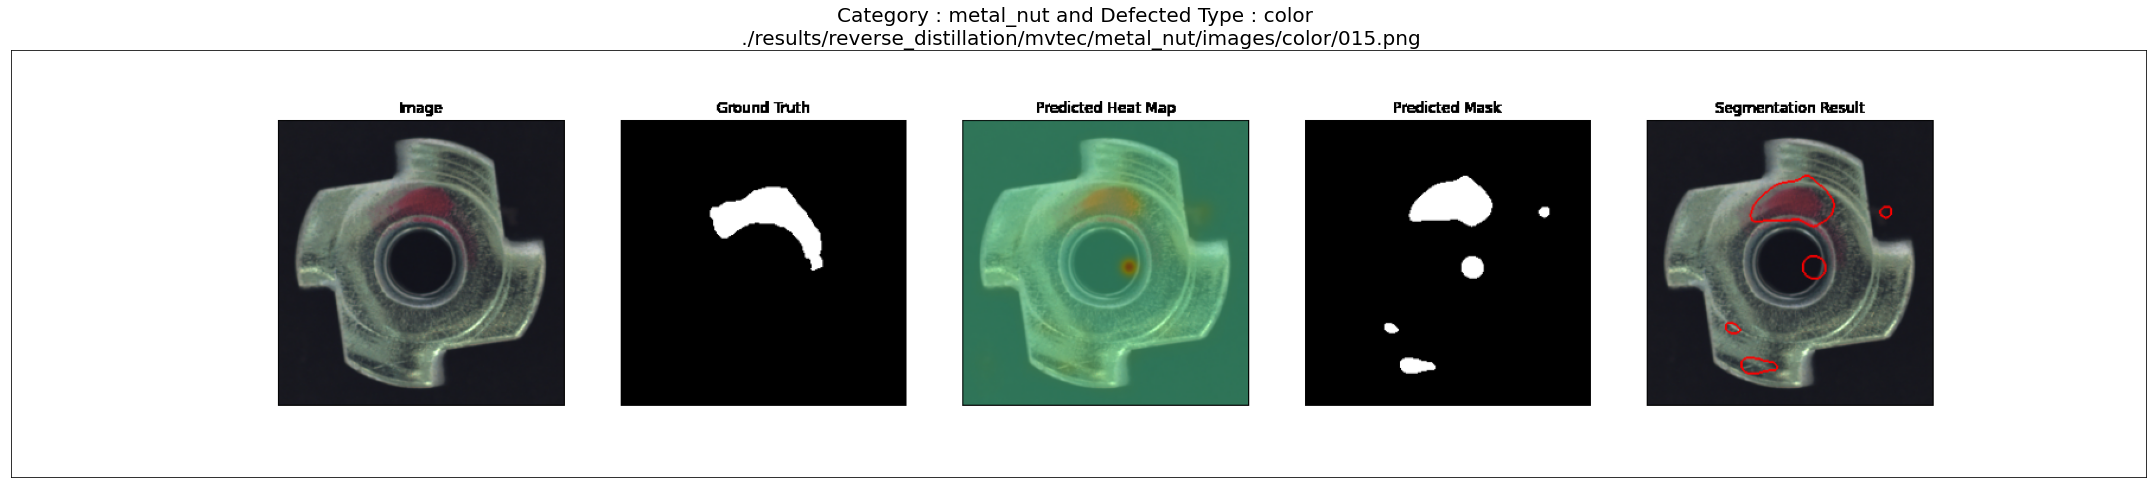

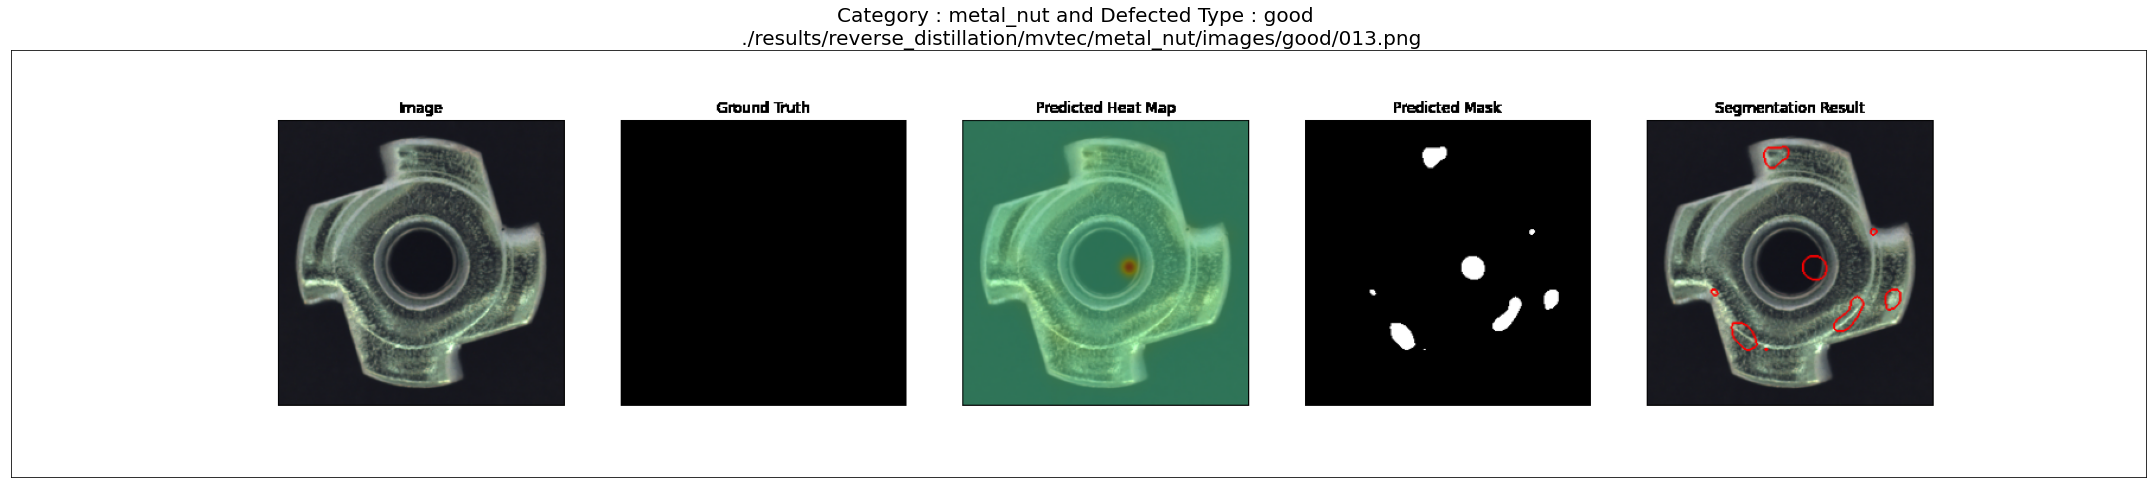

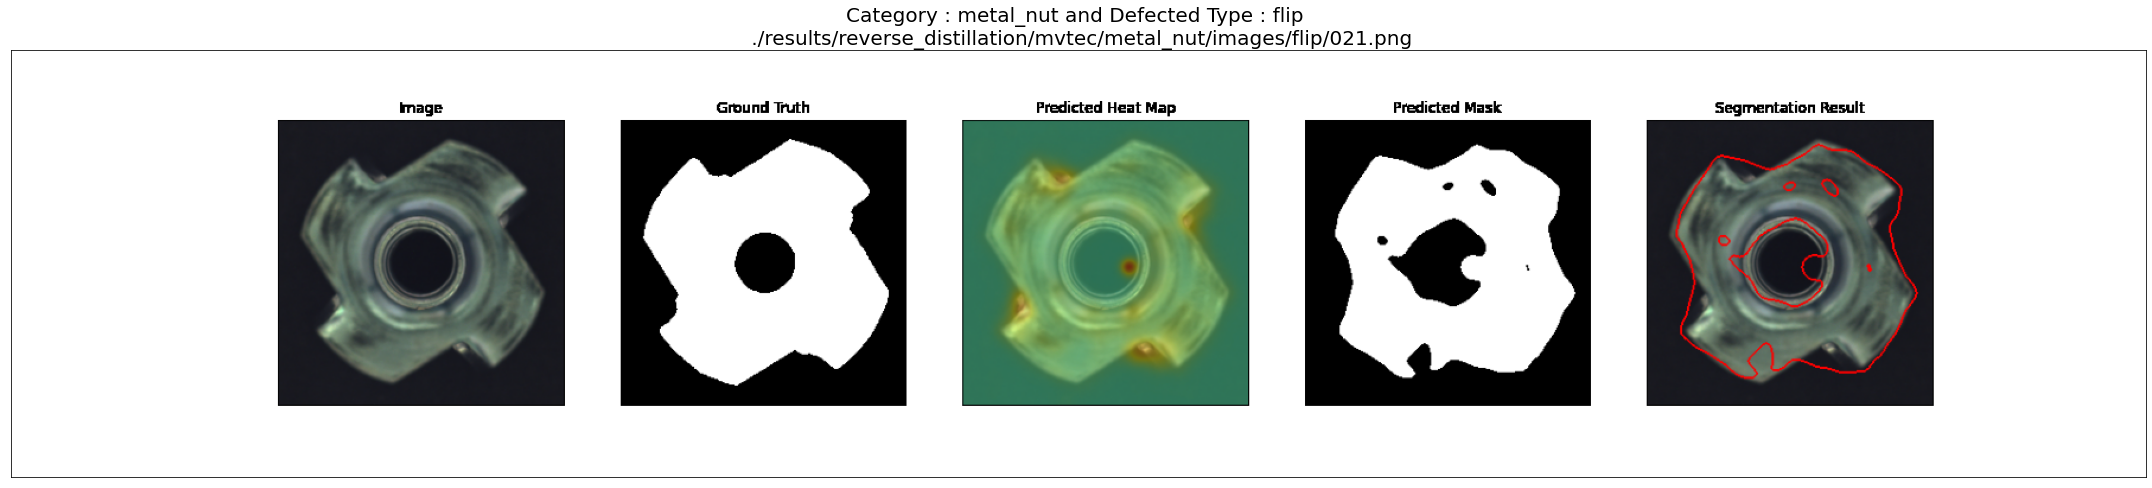

In [ ]:
visualiz(full_path, 10, is_random=True, figsize=(30, 30))

## Inference on new images

In [ ]:
%cd {PROJECT_PATH}

/home/dennishnf/Desktop/unsupervised-anomaly-detection


In [ ]:
infer_resutls = PROJECT_PATH + "/infer_results/"

In [ ]:
# anomalies: color, bent, flip, scratch
# images: 1 to ~20

In [ ]:
# input image
input_img = PROJECT_PATH + "/dataset/MVTec/metal_nut/test/bent/013.png"
input_img

'/home/dennishnf/Desktop/unsupervised-anomaly-detection/dataset/MVTec/metal_nut/test/bent/013.png'

In [ ]:
# output image
output_img = input_img.replace(PROJECT_PATH + "/dataset/MVTec/metal_nut/test/", infer_resutls)
output_img

'/home/dennishnf/Desktop/unsupervised-anomaly-detection/infer_results/bent/013.png'

In [ ]:
# perform inference on the sample image
!python -W ignore anomalib/tools/inference/lightning_inference.py \
        --config {new_yaml_path} \
        --weights {trainer.checkpoint_callback.best_model_path} \
        --input {input_img} \
        --output infer_results

/home/dennishnf/miniconda3/envs/anomalib_env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:51: LightningDeprecationWarning: Setting `Trainer(resume_from_checkpoint=)` is deprecated in v1.5 and will be removed in v1.7. Please pass `Trainer.fit(ckpt_path=)` directly instead.
  rank_zero_deprecation(
/home/dennishnf/miniconda3/envs/anomalib_env/lib/python3.8/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:52: LightningDeprecationWarning: Setting `max_steps = None` is deprecated in v1.5 and will no longer be supported in v1.7. Use `max_steps = -1` instead.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batch

/home/dennishnf/Desktop/unsupervised-anomaly-detection/dataset/MVTec/metal_nut/test/bent/013.png


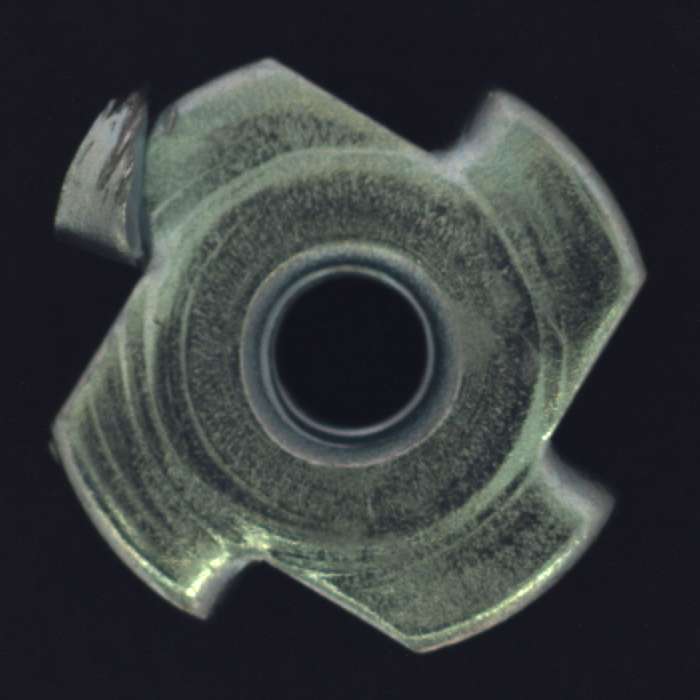

In [ ]:
print(input_img)
display(Image(input_img, width=250))

/home/dennishnf/Desktop/unsupervised-anomaly-detection/infer_results/bent/013.png


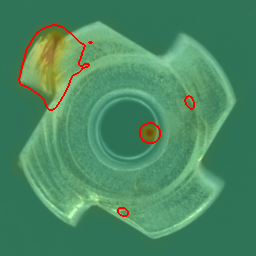

In [ ]:
print(output_img)
display(Image(output_img, width=250))

## Summary of evaluating some arquitectures

```
MODEL = 'padim'
```

```
'image_size': 256,
'train_batch_size': 4,
'test_batch_size': 4,
'max_epochs': 4,
```

```
[{'pixel_F1Score': 0.7553240060806274,
  'pixel_AUROC': 0.9686623215675354,
  'image_F1Score': 0.952380895614624,
  'image_AUROC': 0.9496578574180603}]
```

```
MODEL = 'patchcore'
```

```
'image_size': 128,
'train_batch_size': 1,
'test_batch_size': 1,
'max_epochs': 3,
```

```
[{'pixel_F1Score': 0.8109800219535828,
  'pixel_AUROC': 0.9827464818954468,
  'image_F1Score': 0.9726775884628296,
  'image_AUROC': 0.9833822250366211}]
```

```
MODEL = 'stfpm'
```

```
'image_size': 256,
'train_batch_size': 4,
'test_batch_size': 4,
'max_epochs': 4,
```

```
[{'pixel_F1Score': 0.6699215769767761,
  'pixel_AUROC': 0.9740051627159119,
  'image_F1Score': 0.9555555582046509,
  'image_AUROC': 0.9838709235191345}]
```

```
MODEL = 'fastflow'
```

```
'image_size': 256,
'train_batch_size': 4,
'test_batch_size': 4,
'max_epochs': 4,
```

```
[{'pixel_F1Score': 0.7417428493499756,
  'pixel_AUROC': 0.9636613130569458,
  'image_F1Score': 0.9560439586639404,
  'image_AUROC': 0.9310851097106934}]
```

```
MODEL = 'reverse_distillation'
```

```
'image_size': 256,
'train_batch_size': 4,
'test_batch_size': 4,
'max_epochs': 4,
```

```
[{'pixel_F1Score': 0.7951029539108276,
  'pixel_AUROC': 0.980124831199646,
  'image_F1Score': 0.9723756313323975,
  'image_AUROC': 0.9672531485557556}]
```